<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/Gluonts_tutorial_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install --upgrade mxnet-cu101==1.6.0.post0
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68.7 MB 103 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.7 MB/s 


In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path


# Datasets
The first requirement to use GluonTS is to have an appropriate dataset. GluonTS offers three different options to practitioners that want to experiment with the various modules:使用GluonTS的第一个要求是要有一个合适的数据集。GluonTS为想要尝试各种模块的从业者提供了三种不同的选择。

- Use an available dataset provided by GluonTS使用由GluonTS提供的可用数据集

- Create an artificial dataset using GluonTS使用GluonTS创建一个人工数据集

- Convert your dataset to a GluonTS friendly format 将您的数据集转换为GluonTS的友好格式

In general, a dataset should satisfy some minimum format requirements to be compatible with GluonTS. In particular, it should be an iterable collection of data entries (time series), and each entry should have at least a target field, which contains the actual values of the time series, and a start field, which denotes the starting date of the time series. There are many more optional fields that we will go through in this tutorial.一般来说，一个数据集应该满足一些最低的格式要求，以便与GluonTS兼容。特别是，它应该是一个可迭代的数据条目（时间序列）的集合，每个条目至少应该有一个目标字段，其中包含时间序列的实际值，和一个开始字段，表示时间序列的起始日期。还有许多可选字段，我们将在本教程中进行介绍。

The datasets provided by GluonTS come in the appropriate format and they can be used without any post processing. However, a custom dataset needs to be converted. Fortunately this is an easy task.GluonTS提供的数据集有适当的格式，它们可以不经过任何后期处理就可以使用。然而，自定义的数据集需要进行转换。幸运的是，这是个简单的任务。

## Available datasets in GluonTS
GluonTS comes with a number of available datasets.

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [4]:
from pandas.core.frame import DataFrame
print(f'Available dataset: {list(dataset_recipes.keys())}')

Available dataset: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [5]:
dataset = get_dataset('m4_hourly')

## What is in a dataset?
In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.dataset.train是一个用于训练的数据条目的可重复集合。每个条目对应于一个时间序列。


- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.是一个用于推理的数据条目的可迭代集合。测试数据集是训练数据集的扩展版本，它在每个时间序列的末尾都包含一个在训练中没有出现的窗口。这个窗口的长度等于推荐的预测长度。


- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.dataset.metadata包含数据集的元数据，如时间序列的频率、推荐的预测范围、相关的特征等。


First, let’s see what the first entry of the train dataset contains. We should expect at least a target and a start field in each entry, and the target of the test entry to have an additional window equal to prediction_length.
首先，让我们看看训练数据集的第一个条目包含什么。我们应该期望每个条目中至少有一个目标和一个开始字段，测试条目的目标有一个等于prediction_length的额外窗口。

In [6]:
# get the first time series in the training set

train_entry = next(iter(dataset.train))
train_entry

{'feat_static_cat': array([0], dtype=int32),
 'item_id': 0,
 'start': Period('1750-01-01 00:00', 'H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,

We observe that apart from the required fields there is one more feat_static_cat field (we can safely ignore the source field). This shows that the dataset has some features apart from the values of the time series. For now, we will ignore this field too. We will explain it in detail later with all the other optional fields.我们观察到，除了必要的字段之外，还有一个feat_static_cat字段（我们可以安全地忽略源字段）。这表明，除了时间序列的值之外，数据集还有一些特征。现在，我们也将忽略这个字段。我们将在后面详细解释它和其他所有的可选字段。

We can similarly examine the first entry of the test dataset. We should expect exactly the same fields as in the train dataset.

In [7]:
test_entry = next(iter(dataset.test))
test_entry

{'feat_static_cat': array([0], dtype=int32),
 'item_id': 0,
 'start': Period('1750-01-01 00:00', 'H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,

Moreover, we should expect that the target will have an additional window in the end with length equal to prediction_length. To better understand what this means we can visualize both the train and test time series.此外，我们应该期望目标在最后会有一个额外的窗口，其长度等于预测_length。为了更好地理解这意味着什么，我们可以将训练和测试的时间序列都可视化。

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

test_series

1750-01-01 00:00    605.0
1750-01-01 01:00    586.0
1750-01-01 02:00    586.0
1750-01-01 03:00    559.0
1750-01-01 04:00    511.0
                    ...  
1750-01-31 23:00    785.0
1750-02-01 00:00    756.0
1750-02-01 01:00    719.0
1750-02-01 02:00    703.0
1750-02-01 03:00    659.0
Freq: H, Length: 748, dtype: float32

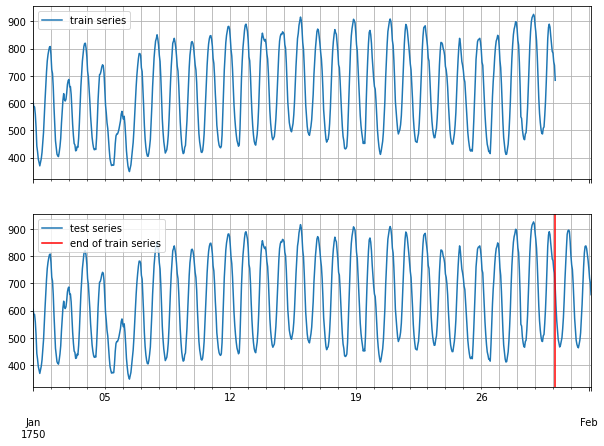

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Create artificial datasets
We can easily create a complex artificial time series dataset using the ComplexSeasonalTimeSeries module.

In [11]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [12]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

We can access some important metadata of the artificial dataset as follows:

In [13]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


The artificial dataset that we created is a list of dictionaries. Each dictionary corresponds to a time series and it should contain the required fields.

In [14]:
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


In [15]:
artificial_dataset.train

[{'item_id': 0,
  'start': Period('1690-02-07 18:00', 'H'),
  'target': array([ 239.62966754,  328.05060092,  457.8858077 ,  572.73386971,
          689.69442493,  841.19099148,  951.45769554, 1084.50115192,
         1155.01712115, 1175.28192849, 1236.31754913, 1251.17807656,
         1199.37914826, 1093.38851752, 1010.7423927 ,  892.67630656,
          771.38996446,  613.53017466,  538.99493852,  497.20213151,
          489.7367022 ,  580.77746298,  796.6504859 , 1079.55861142,
         1243.65255353, 1758.33810934, 2016.17494755, 2408.39483376,
         2887.57502929, 3188.64842561, 3668.1176831 , 3711.52462283,
         3929.61581772, 3898.9619238 , 3657.71016149, 3333.64992326,
         3093.64462467, 2789.17419171, 2320.15791854, 1984.17433115,
         1658.66901509, 1138.40597909, 1215.8985342 , 1018.33623182,
          928.94415343,  894.21014306])},
 {'item_id': 1,
  'start': Period('2002-05-04 15:00', 'H'),
  'target': array([  -32.74601305,  -126.23142705,   -80.08037605,  -

获得了一个数据，每一个点数据都不一样

In order to use the artificially created datasets (list of dictionaries) we need to convert them to ListDataset objects.

In [16]:
train_ds = ListDataset(
    artificial_dataset.train,
    freq=artificial_dataset.metadata.freq
)

test_ds = ListDataset(
    artificial_dataset.test,
    freq=artificial_dataset.metadata.freq
)

In [17]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id'])

In [18]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id'])

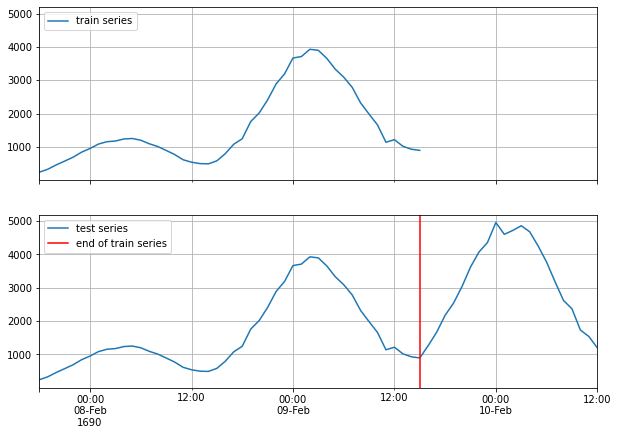

In [19]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Use your time series and features
Now, we will see how we can convert any custom dataset with any associated features to an appropriate format for GluonTS.

As already mentioned a dataset is required to have at least the target and the start fields. However, it may have more. Let’s see what are all the available fields:

In [20]:
from gluonts.dataset.field_names import FieldName

In [21]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

The fields are split into three categories: **the required ones**, the optional ones, and the ones that can be added by the Transformation (explained in a while).这些字段分为三类：必填字段、可选字段、以及可由转换添加的字段（稍后解释）。

1. **Required:**

- start: start date of the time series 时间序列的起始日期

- target: values of the time series 时间序列的数值

2. Optional:

- feat_static_cat: static (over time) categorical features, list with dimension equal to the number of features 静态（随时间变化）的分类特征，列表的维度等于特征的数量

- feat_static_real: static (over time) real features, list with dimension equal to the number of features 静态（随时间变化）的实数特征，列表的维度等于特征的数量

- feat_dynamic_cat: dynamic (over time) categorical features, array with shape equal to (number of features, target length)动态（随时间变化）分类特征，数组的形状等于（特征数，目标长度）。

- feat_dynamic_real: dynamic (over time) real features, array with shape equal to (number of features, target length)动态（随时间变化）的真实特征，数组的形状等于（特征的数量，目标长度）。

3. Added by Transformation:

- time_feat: time related features such as the month or the day与时间相关的特征，如月或日

- feat_dynamic_const: expands a constant value feature along the time axis 沿着时间轴扩展一个常量值特征

- feat_dynamic_age: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp 年龄特征，即对于过去遥远的时间戳来说，其数值较小，而且越接近当前的时间戳，其数值就越单调。

- observed_values: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing 观察值的指标，即一个特征，如果观察到该值则等于1，如果该值缺失则等于0。

- is_pad: indicator for each time step that shows if it is padded (if the length is not enough) 每个时间步骤的指标，显示它是否被填充（如果长度不够的话）

- forecast_start: forecast start date 预测开始日期

As a simple example, we can create a custom dataset to see how we can use some of these fields. The dataset consists of a target, a real dynamic feature (which in this example we set to be the target value one period earlier), and a static categorical feature that indicates the sinusoid type (different phase) that we used to create the target.作为一个简单的例子，我们可以创建一个自定义数据集，看看我们如何使用其中的一些字段。该数据集由一个目标、一个真实的动态特征（在本例中我们将其设置为早一个时期的目标值）和一个静态的分类特征组成，该特征表示我们用来创建目标的正弦类型（不同相位）。

In [22]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate(
        (
            np.tile(
                sin_minusPi_Pi.reshape(1, -1),
                (int(np.ceil(num_series / 2)),1)
            ),
            np.tile(
                sin_Zero_2Pi.reshape(1, -1),
                (int(np.floor(num_series / 2)), 1)
            )
        ),
        axis=0
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (
            np.zeros((num_series, period)),
            target[:, :-period]
        ),
        axis=1
    )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2)))
        ),
        axis=0
    )

    return target, feat_dynamic_real, feat_static_cat

In [23]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 100,
    'num_steps': 24 * 7,
    'prediction_length': 24,
    'freq': '1H',
    'start': [
        pd.Period("01-01-2019", freq='1H')
        for _ in range(100)
    ]
}

In [24]:
data_out = create_dataset(
    custom_ds_metadata['num_series'],
    custom_ds_metadata['num_steps'],
    custom_ds_metadata['prediction_length']
)

target, feat_dynamic_real, feat_static_cat = data_out

In [30]:
target.shape, 24*7, feat_dynamic_real.shape, feat_static_cat

((100, 168),
 168,
 (100, 168),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

We can easily create the train and test datasets by simply filling in the correct fields. Remember that for the train dataset we need to cut the last window.

In [32]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
            feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

In [33]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            feat_static_cat)
    ],
    freq=custom_ds_metadata['freq']
)

Now, we can examine each entry of the train and test datasets. We should expect that they have the following fields: target, start, feat_dynamic_real and feat_static_cat.

In [34]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

In [35]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

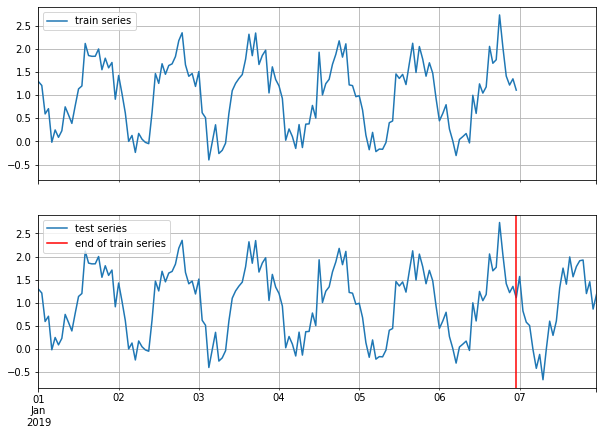

In [36]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

# Transformations

## Define a transformation
The primary use case for a Transformation is for feature processing, e.g., adding a holiday feature and for defining the way the dataset will be split into appropriate windows during training and inference.转换的主要用例是用于特征处理，例如，增加一个假日特征，以及定义数据集在训练和推理过程中被分割成适当窗口的方式。

In general, it gets an iterable collection of entries of a dataset and transform it to another iterable collection that can possibly contain more fields. The transformation is done by defining a set of “actions” to the raw dataset depending on what is useful to our model. This actions usually create some additional features or transform an existing feature. As an example, in the following we add the following transformations:一般来说，它得到一个数据集的可迭代条目集合，并将其转换为另一个可能包含更多字段的可迭代集合。这种转换是通过对原始数据集定义一组 "动作 "来完成的，这取决于什么对我们的模型有用。这些动作通常会创建一些额外的特征或转换一个现有的特征。作为一个例子，在下面我们添加了以下转换。

- AddObservedValuesIndicator: Creates the observed_values field in the dataset, i.e., adds a feature that equals to 1 if the value is observed and 0 if the value is missing 在数据集中创建observed_values字段，即添加一个特征，如果观察到该值，则等于1，如果缺少该值，则等于0。

- AddAgeFeature: Creates the feat_dynamic_age field in the dataset, i.e., adds a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp在数据集中创建feat_dynamic_age字段，即添加一个特征，其值在过去遥远的时间戳中是小的，并且越接近当前时间戳，其值就越单调地增加。


One more transformation that can be used is the InstanceSplitter, which is used to define how the datasets are going to be split in example windows during training, validation, or at prediction time. The InstanceSplitter is configured as follows (skipping the obvious fields):还有一个可以使用的转换是InstanceSplitter，它被用来定义数据集在训练、验证或预测时如何被分割成实例窗口。InstanceSplitter的配置如下（跳过明显的字段）。


- is_pad_field: indicator if the time series is padded (if the length is not enough) 指示器，如果时间序列被填充（如果长度不够）。

- train_sampler: defines how the training windows are cut/sampled 定义训练窗口的切割/取样方式。

- time_series_fields: contains the time dependent features that need to be split in the same manner as the target 包含与时间有关的特征，需要以与目标相同的方式进行分割。

In [37]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [39]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

## Transform a dataset
Now, we can create a transformation object by applying the above transformation to the custom dataset we have created.

In [40]:
transformation = create_transformation(
    custom_ds_metadata['freq'],
    2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

In [41]:
train_tf = transformation(iter(train_ds), is_train=True)

In [42]:
type(train_tf)

generator

As expected, the output is another iterable object. We can easily examine what is contained in an entry of the transformed dataset. The InstanceSplitter iterates over the transformed dataset and cuts windows by selecting randomly a time series and a starting point on that time series (this “randomness” is defined by the instance_sampler).


In [43]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

The transformer has done what we asked. In particular it has added:

a field for observed values (observed_values)

a field for the age feature (feat_dynamic_age)

some extra useful fields (past_is_pad, forecast_start)


It has done one more important thing: it has split the window into past and future and has added the corresponding prefixes to all time dependent fields. This way we can easily use e.g., the past_target field as input and the future_target field to calculate the error of our predictions. Of course, the length of the past is equal to the context_length and of the future equal to the prediction_length.它还做了一件重要的事情：它把窗口分成了过去和未来，并为所有与时间相关的字段添加了相应的前缀。这样，我们就可以很容易地使用例如过去_目标字段作为输入，并使用未来_目标字段来计算我们预测的误差。当然，过去的长度等于context_length，未来的长度等于prediction_length。

In [44]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


Just for comparison, let’s see again what were the fields in the original dataset before the transformation:

In [45]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat']

Now, we can move on and see how the test dataset is split. As we saw, the transformation splits the windows into past and future. However, during inference (is_train=False in the transformation), the splitter always cuts the last window (of length context_length) of the dataset so it can be used to predict the subsequent unknown values of length prediction_length.现在，我们可以继续前进，看看测试数据集是如何分割的。正如我们所看到的，转换将窗口分割成过去和未来。然而，在推理过程中（转换中is_train=False），分割器总是切割数据集的最后一个窗口（长度为context_length），所以它可以被用来预测随后的长度为prediction_length的未知值。

So, how is the test dataset split in past and future since we do not know the future target? And what about the time dependent features?那么，既然我们不知道未来的目标，测试数据集如何在过去和未来中分割？那么与时间有关的特征又是怎样的呢？

In [46]:
from gluonts import transform
test_tf = transformation(iter(test_ds), is_train=False)

test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [47]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


The future target is empty but not the features - we always assume that we know the future features!未来的目标是空的，但特征不是空的--我们总是假设我们知道未来的特征!

All the things we did manually here are done by an internal block called DataLoader. It gets as an input the raw dataset (in appropriate format) and the transformation object and it outputs the transformed iterable dataset batch by batch. The only thing that we need to worry about is setting the transformation fields correctly!所有我们在这里手动做的事情都是由一个叫做DataLoader的内部块完成的。它获取原始数据集（适当的格式）和转换对象作为输入，并逐批输出转换后的可重复数据集。我们唯一需要担心的是正确设置转换字段。

# Training an existing model
GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a “sample path” that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evaluation of the model, to derive statistics, etc.GluonTS带有一些预建的模型。用户所需要做的就是配置一些超参数。现有的模型专注于（但不限于）概率预测。概率预测是以概率分布的形式进行的预测，而不是简单的单点估计。在估计了预测范围内每个时间步骤的未来分布后，我们可以在每个时间步骤从分布中抽取一个样本，从而创建一个 "样本路径"，可以被视为未来的可能实现。在实践中，我们抽取多个样本并创建多个样本路径，这些样本路径可用于可视化、评估模型、得出统计数据等。


## Configuring an estimator
We will begin with GluonTS’s pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.我们将从GluonTS的预建前馈神经网络估计器开始，这是一个简单但强大的预测模型。我们将使用这个模型来演示训练一个模型，产生预测，以及评估结果的过程。

GluonTS’s built-in feedforward neural network (SimpleFeedForwardEstimator) accepts an input window of length context_length and predicts the distribution of the values of the subsequent prediction_length values. In GluonTS parlance, the feedforward neural network model is an example of Estimator. In GluonTS, Estimator objects represent a forecasting model as well as details such as its coefficients, weights, etc.GluonTS的内置前馈神经网络（SimpleFeedForwardEstimator）接受一个长度为context_length的输入窗口，并预测后续预测_length值的分布。在GluonTS的术语中，前馈神经网络模型是Estimator的一个例子。在GluonTS中，Estimator对象代表了一个预测模型，以及它的系数、权重等细节。

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the prediction_length) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).一般来说，每个估计器（预建或定制）都由一些超参数配置，这些超参数可以是所有估计器中共同的（但不具有约束力），也可以是特定的估计器（例如，神经网络的层数或CNN中的步长）。

Finally, each estimator is configured by a **Trainer**, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.最后，每个估计器由训练器配置，训练器定义了模型的训练方式，即历时的数量、学习率等。

In [48]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [49]:
from gluonts.model.estimator import Estimator
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    trainer=Trainer(
        ctx='cpu',
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100

    )
)

## Getting a predictor
After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset dataset.train by invoking the train method of the estimator. The training algorithm returns a fitted model (or a Predictor in GluonTS parlance) that can be used to construct forecasts.在用所有必要的超参数指定了我们的估计器后，我们可以通过调用估计器的训练方法，用我们的训练数据集dataset.train来训练它。训练算法会返回一个拟合的模型（或者用GluonTS的说法是一个预测器），可以用来构建预测。

We should emphasize here that a single model, as the one defined above, is trained over all the time series contained in the training dataset train_ds. This results in a global model, suitable for prediction for all the time series in train_ds and possibly for other unseen related time series.我们应该在这里强调，一个单一的模型，就像上面定义的那样，是在训练数据集train_ds中包含的所有时间序列上训练的。这就产生了一个全局模型，适用于预测train_ds中的所有时间序列，也可能适用于其他未见过的相关时间序列。

In [50]:
train_ds

Map(data=[{'target': array([ 1.29396558e+00,  1.21114838e+00,  5.95295012e-01,  7.08906591e-01,
       -1.72211602e-02,  2.48999059e-01,  8.92886966e-02,  2.30716184e-01,
        7.48439014e-01,  5.74326038e-01,  3.90593767e-01,  7.71947980e-01,
        1.13634872e+00,  1.20068276e+00,  2.11963582e+00,  1.85805416e+00,
        1.84170079e+00,  1.84283304e+00,  2.00066638e+00,  1.55120575e+00,
        1.80108190e+00,  1.59257245e+00,  1.70800483e+00,  9.13042545e-01,
        1.42710233e+00,  1.03560829e+00,  6.13189101e-01,  1.10221526e-03,
        1.29634231e-01, -2.37265512e-01,  1.73933804e-01,  4.84625995e-02,
       -2.04230603e-02, -4.83250357e-02,  6.27848148e-01,  1.46829093e+00,
        1.25604033e+00,  1.68110263e+00,  1.45288682e+00,  1.64262784e+00,
        1.67825186e+00,  1.83560717e+00,  2.17985821e+00,  2.35064721e+00,
        1.65778351e+00,  1.40992355e+00,  1.46980643e+00,  1.19030321e+00,
        1.51265836e+00,  6.20751202e-01,  5.13034284e-01, -3.99916172e-01,
    

In [51]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:01<00:00, 61.10it/s, epoch=5/5, avg_epoch_loss=0.621]


## Saving/Loading an existing model
A fitted model, i.e., a Predictor, can be saved and loaded back easily:

In [54]:
from pathlib import Path

predictor.serialize(Path('/content/'))

## Evaluation
Getting the forecasts
With a predictor in hand, we can now predict the last window of the dataset.test and evaluate our model’s performance.有了预测器，我们现在可以预测数据集.test的最后一个窗口，并评估我们模型的性能。

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:GluonTS自带的make_evaluation_predictions函数可以自动完成预测和模型评估的过程。粗略地说，这个函数执行了以下步骤。

Removes the final window of length prediction_length of the dataset.test that we want to predict
移除我们要预测的dataset.test的最后一个长度为prediction_length的窗口


The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed估算器使用剩余的数据来预测（以样本路径的形式）刚刚删除的 "未来 "窗口

The module outputs the forecast sample paths and the dataset.test (as python generator objects)模块输出预测的样本路径和dataset.test（作为python生成器对象）。

In [55]:
from gluonts.evaluation import make_evaluation_predictions

In [56]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [57]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let’s start with the list containing the time series, i.e., tss. We expect the first entry of tss to contain the (target of the) first time series of test_ds.

In [58]:
# first entry of the time series list

ts_entry = tss[0]

In [60]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([ 1.2939656 ,  1.2111484 ,  0.595295  ,  0.7089066 , -0.01722116],
      dtype=float32)

In [61]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [62]:
test_ds

Map(data=[{'target': array([ 1.29396558e+00,  1.21114838e+00,  5.95295012e-01,  7.08906591e-01,
       -1.72211602e-02,  2.48999059e-01,  8.92886966e-02,  2.30716184e-01,
        7.48439014e-01,  5.74326038e-01,  3.90593767e-01,  7.71947980e-01,
        1.13634872e+00,  1.20068276e+00,  2.11963582e+00,  1.85805416e+00,
        1.84170079e+00,  1.84283304e+00,  2.00066638e+00,  1.55120575e+00,
        1.80108190e+00,  1.59257245e+00,  1.70800483e+00,  9.13042545e-01,
        1.42710233e+00,  1.03560829e+00,  6.13189101e-01,  1.10221526e-03,
        1.29634231e-01, -2.37265512e-01,  1.73933804e-01,  4.84625995e-02,
       -2.04230603e-02, -4.83250357e-02,  6.27848148e-01,  1.46829093e+00,
        1.25604033e+00,  1.68110263e+00,  1.45288682e+00,  1.64262784e+00,
        1.67825186e+00,  1.83560717e+00,  2.17985821e+00,  2.35064721e+00,
        1.65778351e+00,  1.40992355e+00,  1.46980643e+00,  1.19030321e+00,
        1.51265836e+00,  6.20751202e-01,  5.13034284e-01, -3.99916172e-01,
    

In [63]:
# first 5 values
test_ds_entry['target'][:5]

array([ 1.2939656 ,  1.2111484 ,  0.595295  ,  0.7089066 , -0.01722116],
      dtype=float32)

The entries in the forecast list are a bit more complex. They are objects that contain all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.预测列表中的条目更复杂一些。它们是包含所有样本路径的对象，其形式为numpy.ndarray，维度为（num_samples, prediction_length），预测的开始日期，时间序列的频率等。我们可以通过简单调用预测对象的相应属性来获取所有这些信息。

In [64]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [65]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00
Frequency of the time series: <Hour>


#### 关于如何获取不同的预测分位值这件事

We can also do calculations to summarize the sample paths, such as computing the mean or a quantile for each of the 24 time steps in the forecast window.我们还可以进行计算来总结样本路径，比如计算预测窗口中24个时间步骤中每个步骤的平均值或四分位数。

In [66]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.8742349   0.6699756   0.49307853  0.30198094  0.01761629 -0.07720236
 -0.13031487  0.20508589  0.25449836  0.3612777   0.41130462  0.6045264
  1.0669843   1.6777923   1.5878439   1.743725    1.8396341   2.143477
  1.9436449   1.8612062   1.7182541   1.557233    1.3544124   0.9598571 ]
0.5-quantile (median) of the future window:
 [ 0.90690935  0.68700284  0.4770032   0.27434257  0.0411394  -0.11273694
 -0.09833242  0.13896027  0.21604037  0.35700965  0.4743163   0.65917534
  0.97676647  1.3796046   1.5801082   1.746434    1.8513985   2.1175015
  1.9870509   1.8394605   1.75288     1.5889565   1.4048761   0.9539747 ]


In [67]:
print(f"0.7-quantile (median) of the future window:\n {forecast_entry.quantile(0.7)}")

0.7-quantile (median) of the future window:
 [1.1327521  0.8259153  0.6446424  0.44422242 0.18743578 0.04791324
 0.04511845 0.31809092 0.42501414 0.5354834  0.59099376 0.7934583
 1.1324859  1.5570236  1.7076646  1.9336135  1.968263   2.3087118
 2.1135254  1.9682684  1.9183466  1.722352   1.5226804  1.0822594 ]


Forecast objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a “fan chart”.预测对象有一个绘图方法，可以将预测路径总结为平均值、预测区间等。预测区间以不同的颜色作为 "扇形图 "的阴影。

In [68]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

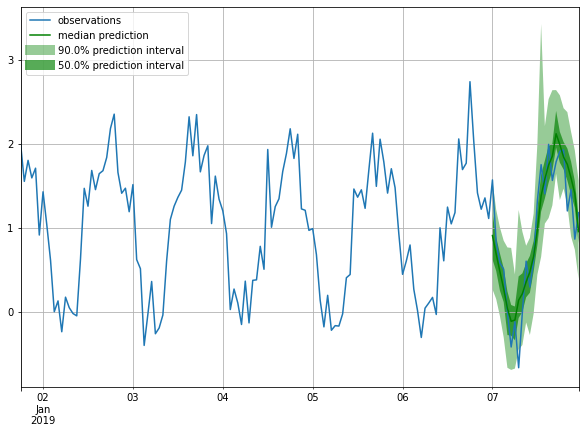

In [69]:
plot_prob_forecasts(ts_entry, forecast_entry)

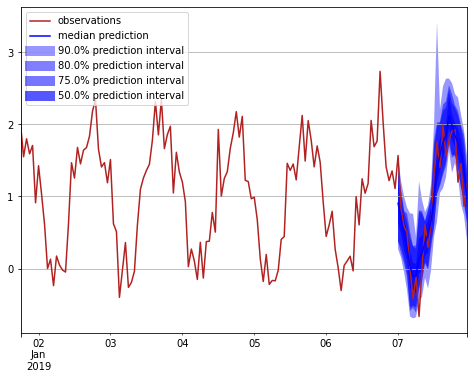

In [88]:
plot_length = 150
prediction_intervals = (50.0, 75.0, 80.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ts_entry[-plot_length:].plot(ax=ax, color='firebrick')  # plot the time series
forecast_entry.plot(prediction_intervals=prediction_intervals, color='blue')
plt.grid(':')
plt.legend(legend, loc="upper left")
plt.show()

## Compute metrics
We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [81]:
from gluonts.evaluation import Evaluator

In [89]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 100it [00:00, 1873.41it/s]


In [85]:
ts_entry[-plot_length:]

,0
2019-01-01 18:00,2.000666
2019-01-01 19:00,1.551206
2019-01-01 20:00,1.801082
2019-01-01 21:00,1.592572
2019-01-01 22:00,1.708005
...,...
2019-01-07 19:00,1.925098
2019-01-07 20:00,1.199304
2019-01-07 21:00,1.455032
2019-01-07 22:00,0.864067


In [90]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.11441325485706327,
    "abs_error": 645.1584784984589,
    "abs_target_sum": 2505.7662086486816,
    "abs_target_mean": 1.0440692536036174,
    "seasonal_error": 0.3370002969106038,
    "MASE": 0.8005533296700484,
    "MAPE": 1.676479473312696,
    "sMAPE": 0.5278605576356251,
    "MSIS": 5.6051928983533745,
    "QuantileLoss[0.1]": 290.4556053500623,
    "Coverage[0.1]": 0.12250000000000001,
    "QuantileLoss[0.5]": 645.1584738334641,
    "Coverage[0.5]": 0.5262500000000001,
    "QuantileLoss[0.9]": 300.25678926110265,
    "Coverage[0.9]": 0.9045833333333333,
    "RMSE": 0.33825028434143745,
    "NRMSE": 0.323973034522339,
    "ND": 0.25746954215907564,
    "wQuantileLoss[0.1]": 0.11591488637190148,
    "wQuantileLoss[0.5]": 0.25746954029737174,
    "wQuantileLoss[0.9]": 0.11982633823728758,
    "mean_absolute_QuantileLoss": 411.9569561482097,
    "mean_wQuantileLoss": 0.16440358830218693,
    "MAE_Coverage": 0.017777777777777795,
    "OWA": NaN
}


In [91]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.104621,6.381886,24.533997,1.022250,0.336414,0.790431,9.136677,0.510020,0.260124,5.927029,3.010076,0.125000,6.381886,0.583333,2.833666,0.958333
1,NaN,0.117194,6.449078,24.575459,1.023977,0.351573,0.764312,0.656491,0.484130,0.262419,4.918669,3.165924,0.083333,6.449078,0.458333,2.886546,0.916667
2,NaN,0.073821,5.473073,24.600300,1.025012,0.367203,0.621031,0.586775,0.464376,0.222480,4.731696,1.906089,0.041667,5.473072,0.583333,2.596611,0.958333
3,NaN,0.167849,7.600630,26.864517,1.119355,0.305599,1.036302,0.590881,0.575014,0.282925,7.901939,2.811095,0.000000,7.600630,0.166667,4.812021,0.625000
4,NaN,0.159890,7.921331,22.494867,0.937286,0.328980,1.003269,8.086316,0.652211,0.352139,7.623374,4.109921,0.375000,7.921331,0.750000,3.201713,0.916667


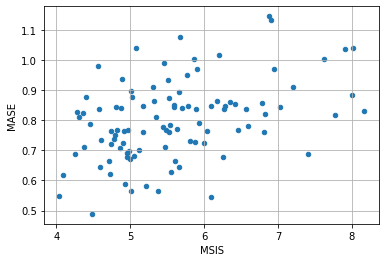

In [92]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Create your own model
For creating our own forecast model we need to:为了创建我们自己的预测模型，我们需要。

1. Define the training and prediction network定义训练和预测网络

2. Define a new estimator that specifies any data processing and uses the networks定义一个新的估计器，指定任何数据处理并使用网络

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:训练和预测网络可以是任意复杂的，但它们应该遵循一些基本规则。

Both should have a `hybrid_forward` method that defines what should happen when the network is called两者都应该有一个hybrid_forward方法，该方法定义了网络被调用时应该发生的情况

The training network’s `hybrid_forward` should return a loss based on the `prediction` and the `true values`训练网络的 hybrid_forward 应该根据预测值和真实值返回一个损失。

The prediction network’s hybrid_forward should return the predictions预测网络的hybrid_forward应该返回预测结果。

The **estimator** should also include the following methods:估算器还应该包括以下方法。

`create_transformation`, defining all the data pre-processing transformations (like adding features) 定义所有的数据预处理转换（如添加特征）。

`create_training_data_loader`, constructing the data loader that gives batches to be used in training, out of a given dataset构建数据加载器，从给定的数据集中提供用于训练的批次。


`create_training_network`, returning the training network configured with any necessary hyperparameters 返回用任何必要的超参数配置的训练网络。

`create_predictor`, creating the prediction network, and returning a `Predictor` object

If a validation dataset is to be accepted, for some validation metric to be computed, then also the following should be defined:

`create_validation_data_loader`

A Predictor defines the predictor.predict method of a given predictor. This method takes the test dataset, it passes it through the prediction network to take the predictions, and yields the predictions. You can think of the Predictor object as a wrapper of the prediction network that defines its predict method.一个预测器定义了一个给定预测器的predictor.predict方法。这个方法接收测试数据集，它通过预测网络来获取预测结果，并得出预测结果。你可以把Predictor对象看作是定义其predict方法的预测网络的一个包装器。

In this section, we will start simple by creating a feedforward network that is restricted to point forecasts. Then, we will add complexity to the network by expanding it to probabilistic forecasting, considering features and scaling of the time series, and in the end we will replace it with an RNN.

We need to emphasize that the way the following models are implemented and all the design choices that are made are neither binding nor necessarily optimal. Their sole purpose is to provide guidelines and hints on how to build a model. 

# Point forecasts with a simple feedforward network
We can create a simple training network that defines a neural network that takes as input a window of length context_length and predicts the subsequent window of dimension prediction_length (thus, the output dimension of the network is prediction_length). The hybrid_forward method of the training network returns the mean of the L1 loss.我们可以创建一个简单的训练网络，定义一个神经网络，将长度为context_length的窗口作为输入，并预测随后维度为prediction_length的窗口（因此，该网络的输出维度为prediction_length）。训练网络的 hybrid_forward 方法返回 L1 损失的平均值。

The prediction network is (and should be) identical to the training network (by inheriting the class) and its hybrid_forward method returns the predictions.预测网络与训练网络（通过继承该类）是（也应该是）相同的，其hybrid_forward方法返回预测结果。

In [93]:
## mx的语法
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))


class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)


The estimator class is configured by a few hyperparameters and implements the required methods.

In [94]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx import (
    batchify,
    copy_parameters,
    get_hybrid_forward_input_names,
    GluonEstimator,
    RepresentableBlockPredictor,
    Trainer,
)
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [95]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

After defining the training and prediction network, as well as the estimator class, we can follow exactly the same steps as with the existing models, i.e., we can specify our estimator by passing all the required hyperparameters to the estimator class, train the estimator by invoking its train method to create a predictor, and finally use the make_evaluation_predictions function to generate our forecasts.

In [100]:
estimator = MyEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [101]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:00<00:00, 125.65it/s, epoch=5/5, avg_epoch_loss=0.285]


The estimator can be trained using our training dataset train_ds just by invoking its train method. The training returns a predictor that can be used to predict.

In [102]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [103]:
forecasts = list(forecast_it)
tss = list(ts_it)

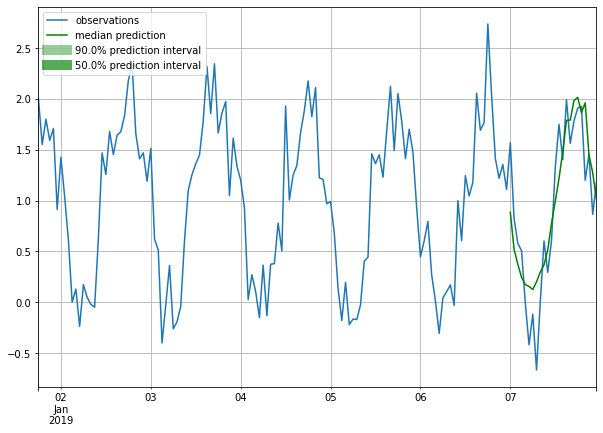

In [104]:
plot_prob_forecasts(tss[0], forecasts[0])

Observe that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates. By requiring 100 sample paths (defined in make_evaluation_predictions) in such a network, we get 100 times the same output.观察一下，我们在预测中实际上看不到任何预测区间。这是意料之中的，因为我们定义的模型并不做概率预测，而只是给出点估计。通过在这样的网络中要求100个样本路径（在make_evaluation_predictions中定义），我们得到100次相同的输出。


## Probabilistic forecasting
### How does a model learn a distribution?
Probabilistic forecasting requires that we learn the distribution of the future values of the time series and not the values themselves as in point forecasting. To achieve this, we need to specify the type of distribution that the future values follow. GluonTS comes with a number of different distributions that cover many use cases, such as Gaussian, Student-t and Uniform just to name a few.概率预测要求我们学习时间序列的未来值的分布，而不是像点预测那样学习值本身。为了实现这一点，我们需要指定未来值所遵循的分布类型。GluonTS提供了许多不同的分布，涵盖了许多使用情况，例如高斯、Student-t和Uniform，仅举几例。


In order to learn a distribution we need to learn its parameters. For example, in the simple case where we assume a Gaussian distribution, we need to learn the mean and the variance that fully specify the distribution.为了学习一个分布，我们需要学习它的参数。例如，在我们假设一个高斯分布的简单情况下，我们需要学习完全指定该分布的平均数和方差。


Each distribution that is available in GluonTS is defined by the corresponding Distribution class (e.g., Gaussian). This class defines -among others- the parameters of the distribution, its (log-)likelihood and a sampling method (given the parameters).GluonTS中的每个分布都是由相应的分布类（如高斯）定义的。这个类定义了分布的参数、它的（对数）似然和采样方法（给定参数）。

However, it is not straightforward how to connect a model with such a distribution and learn its parameters. For this, each distribution comes with a DistributionOutput class (e.g., GaussianOutput). The role of this class is to connect a model with a distribution. Its main usage is to take the output of the model and map it to the parameters of the distribution. You can think of it as an additional projection layer on top of the model. The parameters of this layer are optimized along with the rest of the network.然而，如何将一个模型与这样的分布联系起来并学习它的参数并不简单。为此，每个分布都有一个DistributionOutput类（例如，高斯Output）。这个类的作用是将一个模型与一个分布连接起来。它的主要用途是获取模型的输出并将其映射到分布的参数上。你可以把它看成是模型上面的一个额外的投影层。该层的参数与网络的其他部分一起被优化。

By including this projection layer, our model effectively learns the parameters of the (chosen) distribution of each time step. Such a model is usually optimized by choosing as a loss function the negative log-likelihood of the chosen distribution. After we optimize our model and learn the parameters we can sample or derive any other useful statistics from the learned distributions.
通过包括这个投影层，我们的模型有效地学习了每个时间步骤的（所选）分布的参数。这样的模型通常是通过选择所选分布的负对数似然作为损失函数来优化的。在我们优化模型和学习参数之后，我们可以从学到的分布中取样或得出任何其他有用的统计数据。


## Feedforward network for probabilistic forecasting
Let’s see what changes we need to make to the previous model to make it probabilistic:让我们看看我们需要对之前的模型做哪些改变以使其具有概率性。

First, we need to change the output of the network. In the point forecast network the output was a vector of length prediction_length that gave directly the point estimates. Now, we need to output a set of features that the DistributionOutput will use to project to the distribution parameters. These features should be different for each time step at the prediction horizon. Therefore we need an overall output of `prediction_length * num_features` values.首先，我们需要改变网络的输出。在点预测网络中，输出是一个长度为prediction_length的向量，直接给出点估计。现在，我们需要输出一组特征，DistributionOutput将用来预测分布参数。这些特征对于预测范围内的每个时间步长都应该是不同的。因此，我们需要一个prediction_length * num_features值的总体输出。

The DistributionOutput takes as input a tensor and uses the last dimension as features to be projected to the distribution parameters. Here, we need a distribution object for each time step, i.e., prediction_length distribution objects. Given that the output of the network has `prediction_length * num_features` values, we can reshape it to (prediction_length, num_features) and get the required distributions, while the last axis of length num_features will be projected to the distribution parameters.DistributionOutput将一个张量作为输入，并将最后一维作为投射到分布参数的特征。在这里，我们需要每个时间步长的分布对象，即prediction_length分布对象。鉴于网络的输出有prediction_length * num_features值，我们可以将其重塑为（prediction_length, num_features），并得到所需的分布，而最后一轴的长度num_features将被投影到分布参数上。

We want the prediction network to output many sample paths for each time series. To achieve this we can repeat each time series as many times as the number of sample paths and do a standard forecast for each of them.我们希望预测网络为每个时间序列输出许多样本路径。为了达到这个目的，我们可以将每个时间序列重复的次数与样本路径的数量一样多，并对每个样本路径做一个标准预测。

Note that in all the tensors that we handle there is an initial dimension that refers to the batch, e.g., the output of the network has dimension `(batch_size, prediction_length * num_features).` 请注意，在我们处理的所有张量中，有一个初始维度是指批次，例如，网络的输出有维度（batch_size, prediction_length * num_features）。

In [105]:
from gluonts.mx import DistributionOutput, GaussianOutput

In [106]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(
        self,
        prediction_length,
        distr_output,
        num_cells,
        num_sample_paths=100,
        **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

The changes we need to do at the estimator are minor and they mainly reflect the additional distr_output parameter that our networks use.

In [107]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        distr_output: DistributionOutput,
        num_cells: int,
        num_sample_paths: int = 100,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyProbTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            **kwargs,
        )

    # def create_training_network(self) -> MyTrainNetwork: #orginal
    #     return MyTrainNetwork(
    #         prediction_length=self.prediction_length,
    #         num_cells = self.num_cells  
    #     )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output, #change
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )


        # prediction_network = MyPredNetwork(  # non probabilistic
        #     prediction_length=self.prediction_length, 
        #     num_cells=self.num_cells
        # )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

After defining the training and prediction network, as well as the estimator class, we can follow exactly the same steps as with the existing models, i.e., we can specify our estimator by passing all the required hyperparameters to the estimator class, train the estimator by invoking its train method to create a predictor, and finally use the make_evaluation_predictions function to generate our forecasts.在定义了训练和预测网络以及估计器类之后，我们可以遵循与现有模型完全相同的步骤，也就是说，我们可以通过向估计器类传递所有需要的超参数来指定我们的估计器，通过调用其训练方法来创建一个预测器来训练估计器，最后使用make_evaluation_predictions函数来生成我们的预测结果。

In [110]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [111]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:01<00:00, 56.11it/s, epoch=5/5, avg_epoch_loss=0.339]


In [112]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [113]:
forecasts = list(forecast_it)
tss = list(ts_it)

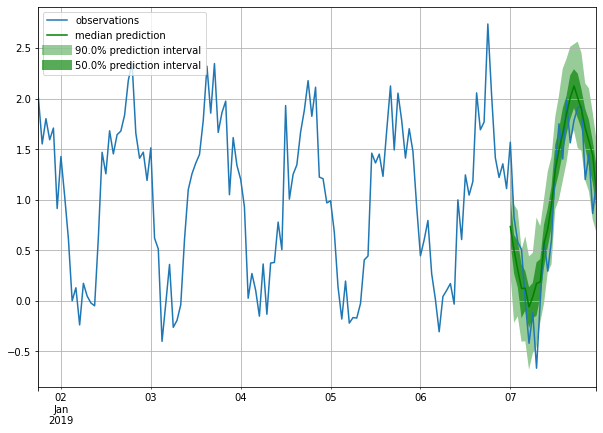

In [114]:
plot_prob_forecasts(tss[0], forecasts[0])

## From feedforward to RNN
In all the previous examples we have used a feedforward neural network as the base for our forecasting model. The main idea behind it was to use as an input to the network a window of the time series (of length context_length) and train the network to forecast the following window (of length prediction_length).在前面所有的例子中，我们使用前馈神经网络作为我们预测模型的基础。其背后的主要想法是将时间序列的一个窗口（长度为context_length）作为网络的输入，并训练网络预测接下来的窗口（长度为prediction_length）。

In this section we will replace the feedforward network with a recurrent neural network (RNN). Due to the different nature of RNNs the structure of the networks will be a bit different. Let’s see what are the major changes.

### Training
The main idea behind RNN is the same as in the feedforward networks we already constructed: as we unroll the RNN at each time step we use as an input past values of the time series and forecast the next value. We can enhance the input by using multiple past values (for example specific lags based on seasonality patterns) or available features. However, in this example we will keep things simple and just use the last value of the time series. The output of the network at each time step is the distribution of the value of the next time step, where the state of the RNN is used as the feature vector for the parameter projection of the distribution.RNN的主要思想与我们已经构建的前馈网络相同：当我们在每个时间步骤中展开RNN时，我们使用时间序列的过去值作为输入并预测下一个值。我们可以通过使用多个过去的值（例如，基于季节性模式的特定滞后期）或可用的特征来增强输入。然而，在这个例子中，我们将保持简单，只使用时间序列的最后一个值。网络在每个时间步骤的输出是下一个时间步骤的值的分布，其中RNN的状态被用作分布的参数投影的特征向量。


Due to the sequential nature of the RNN, the distinction between past_ and future_ in the cut window of the time series is not really necessary. Therefore, we can concatenate past_target and future_target and treat it as a concrete target window that we wish to forecast. This means that the input to the RNN would be (sequentially) the window target[-(context_length + prediction_length + 1):-1] (one time step before the window we want to predict). As a consequence, we need to have context_length + prediction_length + 1 available values at each window that we cut. We can define this in the InstanceSplitter.由于RNN的顺序性，在时间序列的切割窗口中，过去_和未来_的区分其实是没有必要的。因此，我们可以把past_target和future_target连接起来，把它当作我们希望预测的具体目标窗口。这意味着RNN的输入将是（按顺序）目标窗口[-(context_length + prediction_length + 1):-1]（在我们想要预测的窗口之前的一个时间步骤）。因此，我们需要在每个窗口切入时有context_length + prediction_length + 1的可用值。我们可以在InstanceSplitter中定义这一点。

Overall, during training the steps are the following:

1. We pass sequentially through the RNN the target values target[-(context_length + prediction_length + 1):-1]

2. We use the state of the RNN at each time step as a feature vector and project it to the distribution parameter domain

3. The output at each time step is the distribution of the values of the next time step, which overall is the forecasted distribution for the window target[-(context_length + prediction_length):]每个时间步骤的输出是下一个时间步骤的数值分布，总体上是窗口的预测分布，目标[-(context_length + prediction_length) :]

The above steps are implemented in the `unroll_encoder` method.

### Inference
During inference we know the values only of past_target therefore we cannot follow exactly the same steps as in training. However the main idea is very similar:

We pass sequentially through the RNN the past target values past_target[-(context_length + 1):] that effectively updates the state of the RNN

In the last time step the output of the RNN is effectively the distribution of the next value of the time series (which we do not know). Therefore we sample (num_sample_paths times) from this distribution and use the samples as inputs to the RNN for the next time step

We repeat the previous step prediction_length times

The first step is implemented in `unroll_encoder` and the last steps in the sample_decoder method.

In [115]:
from gluonts.

class MyProbRNN(gluon.HybridBlock):
    def __init__(self,
        prediction_length,
        context_length,
        distr_output,
        num_cells,
        num_layers,
        num_sample_paths=100,
        scaling=True,
        **kwargs
     ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            self.rnn = mx.gluon.rnn.HybridSequentialRNNCell()
            for k in range(self.num_layers):
                cell = mx.gluon.rnn.LSTMCell(hidden_size=self.num_cells)
                cell = mx.gluon.rnn.ResidualCell(cell) if k > 0 else cell
                self.rnn.add(cell)

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale is computed on the context length last units of the past target
        # scale shape is (batch_size, 1, *target_shape)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale

    def unroll_encoder(
        self,
        F,
        past_target,
        past_observed_values,
        future_target=None,
        future_observed_values=None
    ):
        # overall target field
        # input target from -(context_length + prediction_length + 1) to -1
        if future_target is not None:  # during training
            target_in = F.concat(
                past_target, future_target, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = F.concat(
                past_observed_values, future_observed_values, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            rnn_length = self.context_length + self.prediction_length
        else:  # during inference
            target_in = past_target.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = past_observed_values.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            rnn_length = self.context_length

        # compute scale
        scale = self.compute_scale(target_in, observed_values_in)

        # scale target_in
        target_in_scale = F.broadcast_div(target_in, scale)

        # compute network output
        net_output, states = self.rnn.unroll(
            inputs=target_in_scale,
            length=rnn_length,
            layout="NTC",
            merge_outputs=True,
        )

        return net_output, states, scale


class MyProbTrainRNN(MyProbRNN):
    def hybrid_forward(
        self,
        F,
        past_target,
        future_target,
        past_observed_values,
        future_observed_values
    ):
        net_output, _, scale = self.unroll_encoder(
            F, past_target, past_observed_values, future_target, future_observed_values
        )

        # output target from -(context_length + prediction_length) to end
        target_out = F.concat(
            past_target, future_target, dim=-1
        ).slice_axis(
            axis=1, begin=-(self.context_length + self.prediction_length), end=None
        )

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(target_out)
        return loss


class MyProbPredRNN(MyProbTrainRNN):
    def sample_decoder(self, F, past_target, states, scale):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_states = [
            s.repeat(repeats=self.num_sample_paths, axis=0)
            for s in states
        ]
        repeated_scale = scale.repeat(repeats=self.num_sample_paths, axis=0)

        # first decoder input is the last value of the past_target, i.e.,
        # the previous value of the first time step we want to forecast
        decoder_input = past_target.slice_axis(
            axis=1, begin=-1, end=None
        ).repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # list with samples at each time step
        future_samples = []

        # for each future time step we draw new samples for this time step and update the state
        # the drawn samples are the inputs to the rnn at the next time step
        for k in range(self.prediction_length):
            rnn_outputs, repeated_states = self.rnn.unroll(
                inputs=decoder_input,
                length=1,
                begin_state=repeated_states,
                layout="NTC",
                merge_outputs=True,
            )

            # project network output to distribution parameters domain
            distr_args = self.proj_distr_args(rnn_outputs)

            # compute distribution
            distr = self.distr_output.distribution(distr_args, scale=repeated_scale)

            # draw samples (batch_size * num_samples, 1)
            new_samples = distr.sample()

            # append the samples of the current time step
            future_samples.append(new_samples)

            # update decoder input for the next time step
            decoder_input = new_samples

        samples = F.concat(*future_samples, dim=1)

        # (batch_size, num_samples, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

    def hybrid_forward(self, F, past_target, past_observed_values):
        # unroll encoder over context_length
        net_output, states, scale = self.unroll_encoder(
            F, past_target, past_observed_values
        )

        samples = self.sample_decoder(F, past_target, states, scale)

        return samples

In [116]:
class MyProbRNNEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        distr_output: DistributionOutput,
        num_cells: int,
        num_layers: int,
        num_sample_paths: int = 100,
        scaling: bool = True,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        )

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length,
            ),
            past_length=self.context_length + 1,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )
        input_names = get_hybrid_forward_input_names(MyProbTrainRNN)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            **kwargs,
        )

    def create_training_network(self) -> MyProbTrainRNN:
        return MyProbTrainRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length + 1,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_DYNAMIC_REAL,
                FieldName.OBSERVED_VALUES,
            ],
        )
        prediction_network = MyProbPredRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )
estimator = MyProbRNNEstimator(
    prediction_length=24,
    context_length=48,
    num_cells=40,
    num_layers=2,
    distr_output=GaussianOutput(),
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        hybridize=False,
        num_batches_per_epoch=100
    )
)

In [117]:
predictor = estimator.train(train_ds)

NameError: ignored

# Data


This tutorial covers how to use GluonTS’s pandas DataFrame based dataset PandasDataset. After going through a few common use cases we explain in detail what data formats PandasDataset can work with, how to include static and dynamic features and how to do train/test splits.

## Introduction
PandasDataset is meant to work on pandas.DataFrame, pandas.Series and any collection of both. The minimal requirement to start modelling using GluonTS’s dataframe dataset is a list of monotonically increasing timestamps with a fixed frequency and a list of corresponding target values in pandas.DataFrame:


GluonTS also supports multiple time series. Those can either be a list of the DataFrames with the format above (having at least a timestamp index or column and target column), a dict of DataFrames or a Long-DataFrame that has an additional item_id column that groups the different time series. When using a dict, the keys are used as item_ids. An example with two time series including static and dynamic feature is the following:GluonTS也支持多个时间序列。这些可以是一个具有上述格式的DataFrame列表（至少有一个时间戳索引或列和目标列），一个DataFrame的dict或者一个Long-DataFrame，它有一个额外的item_id列来分组不同的时间序列。当使用dict时，键被用作 item_ids。下面是一个有两个时间序列的例子，包括静态和动态特征。

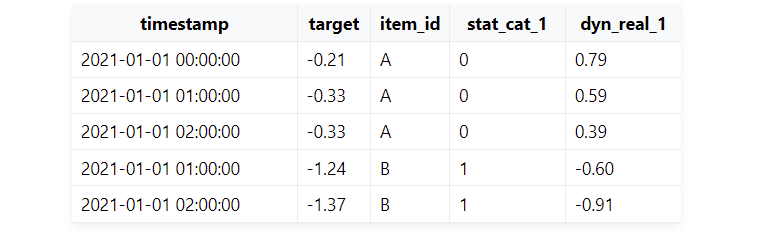

Here, the time series values are represented by the target column with corresponding timestamp values in the timestamp column. Another necessary column is the item_id column that indicates which time series a specific row belongs to. In this example, we have two time series, one indicated by item A and the other by B. In addition, if we have other features we can include those too (stat_cat_1 and dyn_real_1 in the example above). 这里，时间序列值由目标列表示，在时间戳列中有相应的时间戳值。另一个必要的列是 item_id 列，它表示一个特定的行属于哪个时间序列。在这个例子中，我们有两个时间序列，一个由项目A表示，另一个由B表示。此外，如果我们有其他特征，我们也可以包括这些特征（上面例子中的stat_cat_1和dyn_real_1）。


## Use case 1 - Loading data from a long dataframe
In the first use case we are given multiple time series stacked on top of each other in a dataframe with an item_id column that distinguishes different series.

In [118]:
import pandas as pd

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


After reading the data into a pandas.DataFrame we can easily convert it to gluonts.dataset.pandas.PandasDataset and train an estimator an get forecasts.

In [119]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(df, target='target', item_id='item_id')

In [120]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer

In [121]:
ds

PandasDataset(dataframes={'A':                      target item_id
2021-01-01 00:00:00 -1.3378       A
2021-01-01 01:00:00 -1.6111       A
2021-01-01 02:00:00 -1.9259       A
2021-01-01 03:00:00 -1.9184       A
2021-01-01 04:00:00 -1.9168       A
...                     ...     ...
2021-01-10 19:00:00  0.7328       A
2021-01-10 20:00:00  0.4957       A
2021-01-10 21:00:00 -0.1209       A
2021-01-10 22:00:00 -0.5072       A
2021-01-10 23:00:00 -0.6661       A

[240 rows x 2 columns], 'B':                      target item_id
2021-01-01 00:00:00  0.1268       B
2021-01-01 01:00:00  0.0926       B
2021-01-01 02:00:00 -0.1420       B
2021-01-01 03:00:00 -0.4930       B
2021-01-01 04:00:00 -0.5057       B
...                     ...     ...
2021-01-10 19:00:00  0.6937       B
2021-01-10 20:00:00  0.7043       B
2021-01-10 21:00:00  0.5297       B
2021-01-10 22:00:00  0.5816       B
2021-01-10 23:00:00  0.3736       B

[240 rows x 2 columns], 'C':                      target item_id
2021-01-0

In [123]:
estimator = DeepAREstimator(freq=ds.freq, prediction_length=24, trainer=Trainer(epochs=1))
predictor = estimator.train(ds)
predictions = predictor.predict(ds)

100%|██████████| 50/50 [00:06<00:00,  7.54it/s, epoch=1/1, avg_epoch_loss=0.451]


## Use case 2 - Loading data from a wide dataframe
Here, instead of a long dataset, we are given data in the wide format, where time series are stacked side-by-side. To convert the dataset to PandasDataset we first convert it to the long format and then use the PandasDataset.from_long_dataframe constructor.

multi variable

In [124]:
import pandas as pd

url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)
print(df_wide.head())

                          A       B       C       D       E       F       G  \
2021-01-01 00:00:00 -1.3378  0.1268 -0.3645 -1.0864 -2.3803 -0.2447  2.2647   
2021-01-01 01:00:00 -1.6111  0.0926 -0.1364 -1.1613 -2.1421 -0.3477  2.4262   
2021-01-01 02:00:00 -1.9259 -0.1420  0.1063 -1.0405 -2.1426 -0.3271  2.4434   
2021-01-01 03:00:00 -1.9184 -0.4930  0.6269 -0.8531 -1.7060 -0.3088  2.4307   
2021-01-01 04:00:00 -1.9168 -0.5057  0.9419 -0.7666 -1.4287 -0.4284  2.3258   

                          H       I       J  
2021-01-01 00:00:00 -0.7917  0.7071  1.3763  
2021-01-01 01:00:00 -0.9609  0.6413  1.2750  
2021-01-01 02:00:00 -0.9034  0.4323  0.6767  
2021-01-01 03:00:00 -0.9602  0.3193  0.5150  
2021-01-01 04:00:00 -1.2504  0.3660  0.1708  


In [125]:
df_long = pd.melt(df_wide.reset_index(), id_vars="index", value_vars=df_wide.columns)
df_long.head()

,index,variable,value
0,2021-01-01 00:00:00,A,-1.3378
1,2021-01-01 01:00:00,A,-1.6111
2,2021-01-01 02:00:00,A,-1.9259
3,2021-01-01 03:00:00,A,-1.9184
4,2021-01-01 04:00:00,A,-1.9168


In [127]:
df_long.tail()

,index,variable,value
2395,2021-01-10 19:00:00,J,1.2349
2396,2021-01-10 20:00:00,J,1.1525
2397,2021-01-10 21:00:00,J,1.1485
2398,2021-01-10 22:00:00,J,1.3248
2399,2021-01-10 23:00:00,J,1.1657


In [128]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(
    df_long, item_id="variable", target="value", timestamp="index"
)

## Use case 3 - Loading data with missing values
In case the timestamp column is not evenly spaced and monotonically increasing we get an error when using PandasDataset. Here we show how to fill in the gaps that are missing.

Let’s first remove some random rows from the long dataset.

In [129]:
import pandas as pd
import numpy as np

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
remove_ind = np.random.choice(np.arange(df.shape[0]), size=100, replace=False)
mask = [False if i in remove_ind else True for i in range(df.shape[0])]
df_missing_val = df.loc[mask, :] # dataframe with 100 rows removed from df

In [130]:
df_missing_val.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


Now, we group by the item_id and reindex each of the grouped dataframes. Reindexing, as it is done below, will add new rows with NaN values where the data is missing. The user can then use the fillna() method on each dataframe to fill in desired value.

In [131]:
from gluonts.dataset.pandas import PandasDataset

max_end = max(df.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)

ds = PandasDataset(dfs_dict, target="target")

## General use cases
Here, we explain in detail what data formats PandasDataset can work with, how to include static and dynamic features and how to do train/test splits.

### Dummy data generation
Let’s create a function that generates dummy time series conforming above stated requirements (timestamp index and target column). The function randomly samples sin/cos curves and outputs their sum. You don’t need to understand how this really works. We will just call generate_single_ts with datetime values which rise monotonically with fixed frequency and get a pandas.DataFrame with timestamp and target values.

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_single_ts(date_range, item_id=None) -> pd.DataFrame:
    """create sum of `n_f` sin/cos curves with random scale and phase."""
    n_f = 2
    period = np.array([24/(i+1) for i in range(n_f)]).reshape(1, n_f)
    scale = np.random.normal(1, 0.3, size=(1, n_f))
    phase = 2*np.pi*np.random.uniform(size=(1, n_f))
    periodic_f = lambda x: scale*np.sin(np.pi*x/period + phase)

    t = np.arange(0, len(date_range)).reshape(-1,1)
    target = periodic_f(t).sum(axis=1) + np.random.normal(0, 0.1, size=len(t))
    ts = pd.DataFrame({"target": target}, index=date_range)
    if item_id is not None: ts["item_id"] = item_id
    return ts

ts.shape: (240, 1)
                       target
2021-01-01 00:00:00  0.470923
2021-01-01 01:00:00  0.328440
2021-01-01 02:00:00  0.050392
2021-01-01 03:00:00 -0.094943
2021-01-01 04:00:00 -0.283359


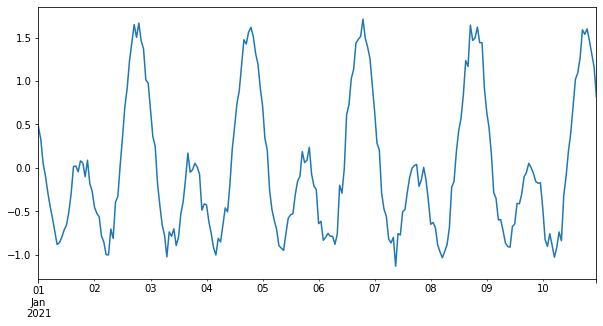

In [134]:
prediction_length, freq = 24, "1H"
T = 10*prediction_length
date_range = pd.date_range("2021-01-01", periods=T, freq=freq)
ts = generate_single_ts(date_range)

print("ts.shape:", ts.shape)
print(ts.head())
ts.loc[:, "target"].plot(figsize=(10, 5))

## Use single time series for training
Now, we create a GluonTS dataset using the time series we generated and train a model. Because we will use the train/evaluation loop multiple times, let’s create a function for it. The input to the function will be the time series in multiple formats and an estimator. The output is the MSE (mean squared error). In this function we train an estimator to get the predictor, use the predictor to create forecasts and return a metric. We also create an DeepAREstimator. Note we run the training for just 1 epoch. Usually you need more epochs to fully train the model.

In [135]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions

def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(dataset=dataset, predictor=predictor)
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]

estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=Trainer(epochs=1)
)

We are ready to convert the ts dataframe into GluonTS dataset and train a model. For that, we import the PandasDataset and create an instance using our time series ts. If the target-column is called “target” we don’t really need to provide it to the constructor. Also freq is inferred from the data if the timestamp is a time- or period range. However, in this tutorial we will be specific on how to use those in general.

In [137]:
ts

,target
2021-01-01 00:00:00,0.470923
2021-01-01 01:00:00,0.328440
2021-01-01 02:00:00,0.050392
2021-01-01 03:00:00,-0.094943
2021-01-01 04:00:00,-0.283359
...,...
2021-01-10 19:00:00,1.600962
2021-01-10 20:00:00,1.463324
2021-01-10 21:00:00,1.312415
2021-01-10 22:00:00,1.159163


In [138]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset(ts, target='target', freq=freq)
train_and_predict(ds, estimator)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


0.05797964334487915

## Use multiple time series for training
As described above, we can also use a list of single time series dataframes. Even dict of dataframes or a single long-formatted-dataframe with multiple time series can be used and is described below. So, let’s create multiple time series and train the model using those.

In [139]:
N = 10
multiple_ts = [generate_single_ts(date_range) for i in range(N)]

ds = PandasDataset(multiple_ts, target='target', freq=freq)
train_and_predict(ds, estimator)

Running evaluation: 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


0.10259047349294029

If the dataset is given as a long-dataframe, we can also use an alternative constructor from_long_dataframe. Note in this case we have to provide the item_id as well.

In [140]:
ts_in_long_format = pd.concat(
    [generate_single_ts(date_range, item_id=i) for i in range(N)]
)

# Note we need an item_id column now and provide its name to the constructor.
# Otherwise, there is no way to distinguish different time series.
ds = PandasDataset.from_long_dataframe(
    ts_in_long_format, item_id="item_id", target="target", freq=freq
)
train_and_predict(ds, estimator)

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 11.18it/s]


0.023407548293471338

## Include static and dynamic features
The PandasDataset also allows us to include features of our time series. The list of all available features is given in the documentation. Here, we use dynamic real and static categorical features. To mimic those features we will just wrap our fancy data generator generate_single_ts and add a static cat and two dynamic real features.

In [141]:
#	item_id 类似于一些参数一类的变量，其他约等于外在特征
def generate_single_ts_with_features(date_range, item_id) -> pd.DataFrame:
    ts = generate_single_ts(date_range, item_id)
    T = ts.shape[0]
    # static features are constant for each series
    ts["static_cat_1"] = np.random.randint(low=0, high=2) # high is exclusive
    ts["dynamic_real_1"] = np.random.normal(size=T)
    ts["dynamic_real_2"] = np.random.normal(size=T)
    # ... we can have as many static or dynamic features as we like
    return ts

ts = generate_single_ts_with_features(date_range, item_id=0)
ts.head()

,target,item_id,static_cat_1,dynamic_real_1,dynamic_real_2
2021-01-01 00:00:00,-0.407726,0,0,0.594536,-0.182426
2021-01-01 01:00:00,-0.187903,0,0,1.589117,-1.107715
2021-01-01 02:00:00,-0.103614,0,0,0.961122,0.588177
2021-01-01 03:00:00,0.177360,0,0,-0.741005,-0.460160
2021-01-01 04:00:00,0.498261,0,0,-0.718761,0.985316


Now, when we create the GluonTS dataset, we need to let the constructor know which columns are the categorical and real features. Also, we need a minor modification to the estimator. We need to let the estimator know as well that more features are coming in. Note, if categorical features are provided, **DeepAR also needs the cardinality as input.** We have one static categorical feature that can take on two values (0 or 1). The cardinality in this case is a list of one element [2,].

cardinality： static categorical feature的种类？

In [142]:
estimator_with_features = DeepAREstimator(
    freq=ds.freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=[2,],
    trainer=Trainer(epochs=1),
)

Let’s now generate single time series and multiple time series (as list and as long-dataframe). Note we don’t provide freq and timestamp, because they are automatically inferred from the index. We are also not passing the target argument, since it’s default value is “target”, which is the target column in our dataframes.

In [149]:
multiple_ts

[                       target  item_id  static_cat_1  dynamic_real_1  \
 2021-01-01 00:00:00  0.288715        0             1       -1.702682   
 2021-01-01 01:00:00  0.147529        0             1       -0.212922   
 2021-01-01 02:00:00  0.246561        0             1       -0.183644   
 2021-01-01 03:00:00  0.004170        0             1       -0.784304   
 2021-01-01 04:00:00 -0.269245        0             1       -1.175572   
 ...                       ...      ...           ...             ...   
 2021-01-10 19:00:00  0.241649        0             1       -0.091578   
 2021-01-10 20:00:00  0.470476        0             1        0.295864   
 2021-01-10 21:00:00  0.189219        0             1        1.400941   
 2021-01-10 22:00:00  0.485548        0             1       -0.493612   
 2021-01-10 23:00:00  0.304296        0             1       -1.613995   
 
                      dynamic_real_2  
 2021-01-01 00:00:00       -0.505346  
 2021-01-01 01:00:00       -0.396179  
 2021

In [146]:
multiple_ts_long

,target,item_id,static_cat_1,dynamic_real_1,dynamic_real_2
2021-01-01 00:00:00,0.288715,0,1,-1.702682,-0.505346
2021-01-01 01:00:00,0.147529,0,1,-0.212922,-0.396179
2021-01-01 02:00:00,0.246561,0,1,-0.183644,-2.869611
2021-01-01 03:00:00,0.004170,0,1,-0.784304,0.981298
2021-01-01 04:00:00,-0.269245,0,1,-1.175572,0.828310
...,...,...,...,...,...
2021-01-10 19:00:00,0.037364,9,1,2.097965,-0.023335
2021-01-10 20:00:00,-0.263658,9,1,-0.077359,0.479344
2021-01-10 21:00:00,-0.238231,9,1,0.801305,-0.345370
2021-01-10 22:00:00,-0.269765,9,1,-1.756684,1.387625


In [143]:
single_ts = generate_single_ts_with_features(date_range, item_id=0)
multiple_ts = [generate_single_ts_with_features(date_range, item_id=i) for i in range(N)]
multiple_ts_long = pd.concat(multiple_ts)

single_ts_dataset = PandasDataset(
    single_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    feat_static_cat=["static_cat_1"],
)

# Three method
multiple_ts_dataset = PandasDataset(
    multiple_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    feat_static_cat=["static_cat_1"],
)
multiple_ts_dataset_dict = PandasDataset(
    {i: _ts for i, _ts in enumerate(multiple_ts)},
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    feat_static_cat=["static_cat_1"],
)
# for long-dataset we use a different constructor and need a `item_id` column
multiple_ts_long_dataset = PandasDataset.from_long_dataframe(
    multiple_ts_long,
    item_id="item_id",
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    feat_static_cat=["static_cat_1"],
)

That’s it! We can now call train_and_predict with all the datasets.

In [144]:
train_and_predict(single_ts_dataset, estimator_with_features)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


0.016801548500855763

In [150]:
train_and_predict(multiple_ts_dataset, estimator_with_features)

Running evaluation: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


0.05449147224426269

In [151]:
train_and_predict(multiple_ts_dataset_dict, estimator_with_features)

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 10.93it/s]


0.0524069366355737

In [152]:
train_and_predict(multiple_ts_long_dataset, estimator_with_features)

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


0.0434775184839964

## Use train/test split
Here, we split the DataFrame/DataFrames into training and test data. We can then use the training data to train the model and the test data for prediction. For training we will use the entire dataset up to last prediction_length entries. For testing we feed the entire dataset into `make_evaluation_predictions`, which automatically splits the last prediction_length entries for us and returns their predictions. Then, we forward those predictions to the Evaluator, which calculates a bunch of metrics for us (including MSE, RMSE, MAPE, sMAPE, …).

In [153]:
to_pandasdataset = lambda data: PandasDataset(
    data,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    feat_static_cat=["static_cat_1"],
)
train = to_pandasdataset([ts.iloc[:-prediction_length, :] for ts in multiple_ts])
test = to_pandasdataset(multiple_ts)

In [154]:
predictor = estimator_with_features.train(train)
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(test))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 10.95it/s]


In [155]:
prediction_length

24

### Train and visualize forecasts
Let’s generate 100 time series dataframes, create a train/test split, train an estimator and visualize the forecasts.

### 同时预测100个df?

In [156]:
prediction_length, freq = 24, "1H"
T = 10*prediction_length
date_range = pd.date_range("2021-01-01", periods=T, freq=freq)

N = 100
time_seriess = [generate_single_ts(date_range, item_id=i) for i in range(N)]

train = PandasDataset([ts.iloc[:-prediction_length, :] for ts in time_seriess])
test = PandasDataset(time_seriess)

In [159]:
ts

,target,item_id,static_cat_1,dynamic_real_1,dynamic_real_2
2021-01-01 00:00:00,-0.407726,0,0,0.594536,-0.182426
2021-01-01 01:00:00,-0.187903,0,0,1.589117,-1.107715
2021-01-01 02:00:00,-0.103614,0,0,0.961122,0.588177
2021-01-01 03:00:00,0.177360,0,0,-0.741005,-0.460160
2021-01-01 04:00:00,0.498261,0,0,-0.718761,0.985316
...,...,...,...,...,...
2021-01-10 19:00:00,-1.558275,0,0,-1.193919,-0.384476
2021-01-10 20:00:00,-1.197481,0,0,-1.439842,-0.820376
2021-01-10 21:00:00,-1.195109,0,0,-0.934641,0.801695
2021-01-10 22:00:00,-1.189511,0,0,-1.444935,-2.411417


In [157]:
from gluonts.model.forecast import Forecast
test = PandasDataset(time_seriess)
estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(epochs=10),
)

predictor = estimator.train(train)
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 2530.00it/s]


In [169]:
forecasts[99]

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=numpy.array([[0.13606274127960205, 0.3722768723964691, 0.724949836730957, 0.8060086965560913, 1.0676401853561401, 0.9903596639633179, 1.3043317794799805, 1.5216622352600098, 1.5545779466629028, 1.439244270324707, 1.572614073753357, 1.1715365648269653, 0.9689147472381592, 0.7567798495292664, 0.4404875934123993, 0.09508522599935532, -0.3011294901371002, -0.5079899430274963, -0.868208110332489, -1.2489553689956665, -1.1552562713623047, -1.377975344657898, -1.4911586046218872, -1.3302797079086304], [0.374107301235199, 0.3862679600715637, 0.8391121625900269, 1.1141127347946167, 1.2939503192901611, 1.7247527837753296, 1.6491084098815918, 2.113032102584839, 1.7970852851867676, 1.694935917854309, 1.5772515535354614, 1.3197726011276245, 0.9002010822296143, 0.5874871015548706, 0.46730268001556396, 0.20780715346336365, -0.34960222244262695, -0.7378137111663818, -0.9525584578514099, -1.0952144861221313, -1.0914678573608398, -1.

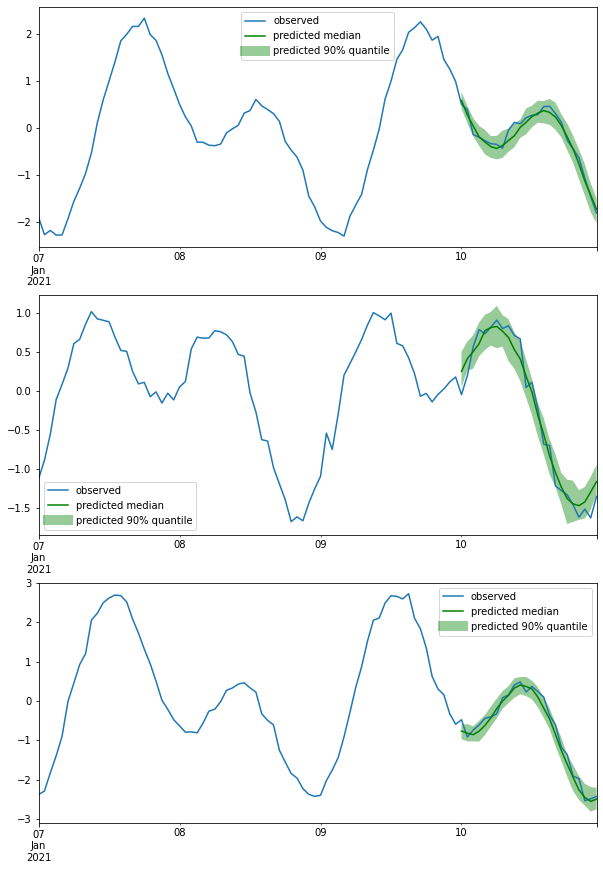

In [170]:
n_plot = 3
indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    tests[index][-4*prediction_length:].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(prediction_intervals=[90.], color='g')
    plt.legend(["observed", "predicted median", "predicted 90% quantile"])